In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('Preprocessed_data.csv')
data

,Title,category
0,campbell natural light italianstyle vegetable ...,Grocery and Gourmet Food
1,hawaiian sun strawberry guava jam large,Grocery and Gourmet Food
2,beef flat iron natural angus choice xoz,Grocery and Gourmet Food
3,k coffee company sierra madre central american...,Grocery and Gourmet Food
4,cafix coffee substitute ounce per case,Grocery and Gourmet Food
...,...,...
79995,pleaser woman kissuvwsanw platform dress sandal,Clothing Shoes and Jewelry
79996,mordenmiss woman autumn casual dress travel ho...,Clothing Shoes and Jewelry
79997,friendshop sheer back slim clubwear cocktail h...,Clothing Shoes and Jewelry
79998,seya twotone modern jewelry box organizer,Clothing Shoes and Jewelry


In [3]:
# Shuffling a Pandas dataframe with .shuffle()
data = data.sample(frac=1).reset_index(drop=True)
data

,Title,category
0,mayhem blood official men new black shirt,Clothing Shoes and Jewelry
1,michael kor woman twotone parker watch,Clothing Shoes and Jewelry
2,headless bicycle rider graveyard school,Books
3,lake champlain dark chocolate almond caramel c...,Grocery and Gourmet Food
4,master airbrush brand set airbrush quick relea...,Arts Crafts and Sewing
...,...,...
79995,air king d inch designer series cabinet range ...,Others
79996,mirenesse cosmetic touch concealer longwear mi...,Beauty
79997,toute nuit facial wrinkle flattening patch nda...,Beauty
79998,hobbytiger lipo life battery balance charger p...,Toys and Games


In [4]:
#preparing y

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
labelEncode = le.fit_transform(data["category"])
print("LabelEncode")
print(labelEncode)
categorical_y = to_categorical(labelEncode)
print("To_Categorical")
print(categorical_y)

LabelEncode
[3 3 2 ... 1 7 7]
To_Categorical
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [5]:
textList=[]
for text in data["Title"]:
    textList.append(text)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#preparing x for ANN
tfidv = TfidfVectorizer()
x = tfidv.fit_transform(textList)
x.sort_indices()

x_train,x_test,y_train,y_test = train_test_split(x,categorical_y,test_size=0.2,random_state=42)

In [7]:
y_train.shape

(64000, 8)

# ANN

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax, Adam, SGD # - Works
from keras.utils.vis_utils import plot_model
from keras.losses import categorical_crossentropy

def build_ann_model(x_train):
    model = Sequential()
    
    model.add(Dense(units=1024,activation="relu",input_dim=x_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=y_train.shape[1],activation="softmax"))
    #2=> 0.01 and 15 iteration
    optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam")
    
    model.compile(optimizer=optimizer,metrics=["accuracy"],loss=categorical_crossentropy)
    return model

In [11]:
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import accuracy_score
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC


def select_features_CH2(p,x_train, y_train, x_test):
    CH2 = SelectPercentile(chi2, percentile=p)
    CH2.fit(x_train, y_train)
    x_train_CH2 = CH2.transform(x_train)
    x_test_CH2 = CH2.transform(x_test)
    return x_train_CH2, x_test_CH2, CH2

accuracies = {}

for p in range(5, 105, 5):
    print("Percentage of features is:", p)
    x_train_CH2, x_test_CH2, CH2 = select_features_CH2(p,x_train, y_train, x_test)
    n = x_train_CH2.shape[1]
    print("Number of features is:", n)
    ann_model = build_ann_model(x_train_CH2)
    #plot_model(ann_model,show_shapes=True)


    ann_history = ann_model.fit(x_train_CH2,y_train,epochs=20,batch_size=200,shuffle=True)
    y_pred = ann_model.predict(x_test_CH2)



    accuracy = accuracy_score(y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
    print("Accuracy for the {} best features is: {}%".format(n, accuracy))
    ss = "ANN_p-"+str(p)+"_n-"+str(n)+"_acc-"+str(accuracy)+".pickle"
    pickle.dump(ann_model, open(ss, "wb"))
    accuracies[p] = [n, accuracy, ss]

Percentage of features is: 5
Number of features is: 2955
Epoch 1/20
320/320 [==============================] - 3s 6ms/step - loss: 2.0739 - accuracy: 0.2204
Epoch 2/20
320/320 [==============================] - 2s 6ms/step - loss: 2.0459 - accuracy: 0.3987
Epoch 3/20
320/320 [==============================] - 3s 10ms/step - loss: 1.9319 - accuracy: 0.5234
Epoch 4/20
320/320 [==============================] - 4s 10ms/step - loss: 1.6385 - accuracy: 0.6251
Epoch 5/20
320/320 [==============================] - 4s 11ms/step - loss: 1.2835 - accuracy: 0.7113
Epoch 6/20
320/320 [==============================] - 3s 9ms/step - loss: 1.0238 - accuracy: 0.7523
Epoch 7/20
320/320 [==============================] - 2s 6ms/step - loss: 0.8633 - accuracy: 0.7732
Epoch 8/20
320/320 [==============================] - 3s 7ms/step - loss: 0.7627 - accuracy: 0.7893
Epoch 9/20
320/320 [==============================] - 3s 7ms/step - loss: 0.7016 - accuracy: 0.7995
Epoch 10/20
320/320 [===================

In [20]:
from sklearn.feature_selection import SelectPercentile, chi2
from tensorflow import keras
CH2 = SelectPercentile(chi2, percentile=85)
CH2.fit(x_train, y_train)
x_train_CH2=CH2.transform(x_train)
x_test_CH2 = CH2.transform(x_test)


ann_model = pickle.load(open('ANN_p-85_n-50224_acc-0.89775.pickle',"rb"))
y_pred = ann_model.predict(x_test_CH2)
print("Number of features is:", x_train_CH2.shape[1])
ann_accuracy = accuracy_score(y_test.argmax(axis=-1),y_pred.argmax(axis=-1))

print("The best accuracy after feature selection is" , ann_accuracy)

Number of features is: 50224
The best accuracy after feature selection is 0.89775


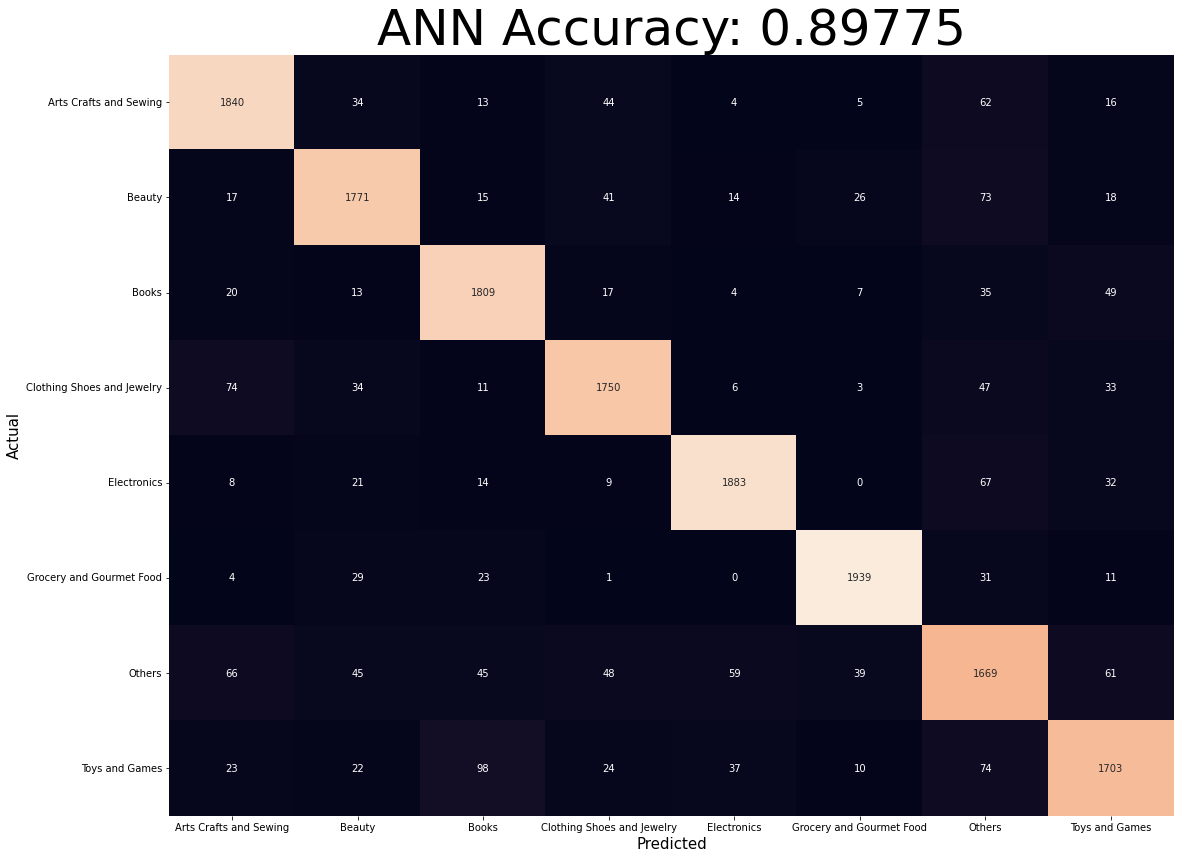

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
ann_accuracy = accuracy_score(y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
#print("ANN Accuracy:",ann_accuracy)
ann_cn = confusion_matrix(y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(ann_cn,annot=True,fmt="1d",cbar=False,xticklabels=le.classes_,yticklabels=le.classes_)
plt.title("ANN Accuracy: {}".format(ann_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

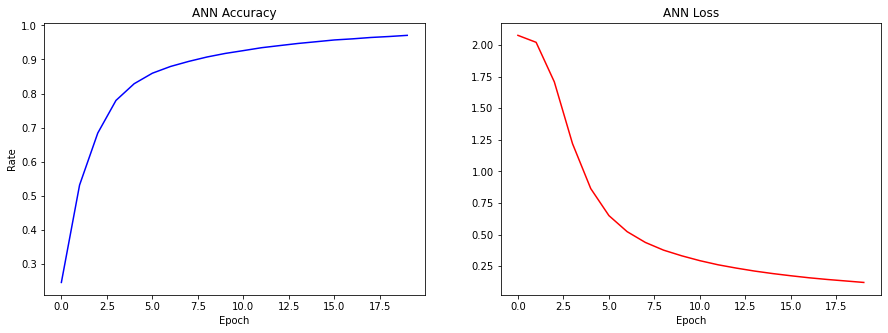

In [22]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(ann_history.history["accuracy"],label="accuracy",color="blue")
axe1[1].plot(ann_history.history["loss"],label="loss",color="red")
axe1[0].title.set_text("ANN Accuracy")
axe1[1].title.set_text("ANN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

# True Positive, True Negative, False Positive and False Negative

In [25]:
cm=confusion_matrix(y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
import numpy as np
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('True positive rate',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('True negative rate',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive rate',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate',FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('ACC',ACC)
print('**********************************')
acc = np.diag(cm).sum() / cm.sum()
print('acc',acc)


True positive rate [0.91179386 0.89670886 0.92579324 0.89376915 0.92576205 0.95142296
 0.82135827 0.85534907]
True negative rate [0.98483765 0.98588235 0.98440837 0.98689645 0.99112129 0.99355393
 0.97215063 0.98429581]
False positive rate [0.01516235 0.01411765 0.01559163 0.01310355 0.00887871 0.00644607
 0.02784937 0.01570419]
False negative rate [0.08820614 0.10329114 0.07420676 0.10623085 0.07423795 0.04857704
 0.17864173 0.14465093]
ACC [0.975625  0.974875  0.97725   0.9755    0.9828125 0.9881875 0.953
 0.96825  ]
**********************************
acc 0.89775
